In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import warnings
warnings.filterwarnings('ignore')
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

article = pd.read_csv('../data/article_info.csv')

titles = article['Title'].tolist()
t_embeddings = model.encode(titles)

contents = article['Content'].tolist()
c_embeddings = model.encode(contents)

# 유저별로 조회한 기사들의 임베딩을 추출 (예시로 title 임베딩 사용)
user_article_data = pd.read_csv('../data/view_log.csv')  # 유저-기사 조회 기록


/home/elicer/.anaconda3/envs/dacon/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-10-26 13:18:19.908850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 13:18:19.924054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 13:18:19.944854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one ha

In [3]:
np.savetxt('../cached/t_embedding', t_embeddings)
np.savetxt('../cached/c_embedding', c_embeddings)

In [6]:
import sys
sys.path.append('../')
from modules.data import *
from modules.utils import *
config = get_jupyter_args()
config.model = 'temp'
storage = DataStorage(config)

In [8]:
user_article_data, _ = storage.load_train_dataset()

In [11]:
t_cosine_sim = util.cos_sim(t_embeddings, t_embeddings)
c_cosine_sim = util.cos_sim(c_embeddings, c_embeddings)

In [79]:
def get_user_cosine_sim(embedding):
    # 유저별로 코사인 유사도를 저장할 딕셔너리
    user_cosine_sims = {}
    user_cosine_means = {}

    # 각 유저별 조회한 기사들의 코사인 유사도 계산
    for user_id in user_article_data['userID'].unique():
        # 해당 유저가 조회한 기사 ID 추출
        user_articles = user_article_data[user_article_data['userID'] == user_id]['articleID'].tolist()
        
        # 조회한 기사들의 코사인 유사도 행렬에서 유저가 본 기사에 해당하는 부분 추출
        if len(user_articles) > 1:
            # 기사 ID에 해당하는 코사인 유사도 행렬 부분 추출
            user_sim_matrix = embedding[np.ix_(user_articles, user_articles)]
            
            # 상삼각행렬의 유사도 값만 추출 (자기 자신과의 유사도는 제외)
            triu_indices = np.triu_indices_from(user_sim_matrix, k=1)
            user_sim_values = user_sim_matrix[triu_indices]
            print(user_sim_values)
            
            # 유사도 값 저장
            user_cosine_sims[user_id] = user_sim_values
            
            # 유사도 평균값 저장
            user_cosine_means[user_id] = np.mean(user_sim_values.cpu().numpy())
        else:
            # 기사 1개 이하일 경우 유사도를 계산할 수 없으므로 NaN 처리
            user_cosine_sims[user_id] = np.nan
            user_cosine_means[user_id] = np.nan

    return user_cosine_sims, user_cosine_means


In [80]:
user_cosine_sims, user_cosine_means = get_user_cosine_sim(c_cosine_sim)

tensor([ 0.0740,  0.1067,  0.1359,  0.2945,  0.2333,  0.2333,  0.0293,  0.3631,
         0.3812,  0.0293,  0.1200,  0.0893,  0.0819,  0.0740,  0.1466,  0.1510,
         0.0293,  0.2287,  0.1067,  0.2287,  0.1706,  0.1706, -0.1170,  0.0543,
         0.1664,  0.2711,  0.3631,  0.2420,  0.0144,  0.1767,  0.0127,  0.0293,
         0.1803,  0.1706,  0.1866,  0.1626,  0.1048,  0.1701,  0.1701,  0.3923,
         0.1768,  0.2463,  0.3923,  0.4067, -0.0292,  0.0397,  1.0000,  0.2241,
         0.0803,  0.3923,  0.2162,  0.1866,  0.2162,  0.0931,  0.0931,  0.1134,
         0.2401,  0.0381,  0.1971,  0.1768,  0.1664,  0.2092,  0.0974,  0.2846,
         0.3923,  0.2134,  0.0931,  0.1667,  0.1250,  0.4264,  0.4264,  0.1300,
         0.1422,  0.2479,  0.1300,  0.1760,  0.3779,  0.1165,  0.1866,  0.3992,
         0.4781,  0.1300,  0.2788,  1.0000,  0.2788,  0.1135,  0.1135,  0.2336,
         0.1982,  0.2487,  0.1190,  0.1422,  0.2483,  0.0803,  0.2346,  0.2962,
         0.1300,  0.2651,  0.1135,  0.42

In [27]:
c_cosine_sim[0, 1]

tensor(0.0756)

In [71]:
import numpy as np
import random

# 무작위 기사 쌍의 유사도 추출
random_sim_values = []
num_samples = 5  # 샘플링할 무작위 쌍의 개수

for _ in range(num_samples):
    # 임의로 두 개의 기사 ID 선택
    idx1, idx2 = random.sample(range(0,3008), 2)
    # 코사인 유사도 행렬에서 무작위 기사 쌍의 유사도 추출
    random_sim_values.append(c_cosine_sim[idx1, idx2].cpu().numpy())

# 무작위 유사도 평균 및 분포 확인
random_sim_values = np.array(random_sim_values)
random_mean = np.mean(random_sim_values)
random_std = np.std(random_sim_values)

In [66]:
random_sim_values.shape

(100,)

In [75]:
from scipy import stats

# 유저별 코사인 유사도 평균 배열 생성
user_means = np.array(list(user_cosine_means.values()))

# 유저 유사도 평균과 무작위 유사도 평균을 비교하는 T-검정
t_stat, p_value = stats.ttest_1samp(user_means[~np.isnan(user_means)], random_mean, alternative='less')
print("T-검정 통계량:", t_stat)
print("p-값:", p_value)


T-검정 통계량: 29.451033812327335
p-값: 1.0


In [72]:
from scipy import stats

# 유저 유사도 평균 배열 생성
user_means = np.array(list(user_cosine_means.values()))
user_means = user_means[~np.isnan(user_means)]  # NaN 제거

# 무작위 유사도 평균 배열 생성
random_means = random_sim_values  # 무작위 유사도 값 목록을 사용

# 두 샘플 간의 T-검정 수행
t_stat, p_value = stats.ttest_ind(user_means, random_means, alternative='less')
print("T-검정 통계량:", t_stat)
print("p-값:", p_value)


T-검정 통계량: 1.8117751747194701
p-값: 0.9648761146994269


1415

In [48]:
from scipy import stats

# 유저 유사도 평균 배열 생성
user_means = np.array(list(user_cosine_means.values()))
user_means = user_means[~np.isnan(user_means)]  # NaN 제거


# 단측 T-검정: 유저 평균 유사도가 무작위 평균 유사도보다 크지 않다고 가정
t_stat, p_value = stats.ttest_1samp(user_means, random_mean, alternative='less')
print("T-검정 통계량:", t_stat)
print("p-값:", p_value)

T-검정 통계량: 23.657024886969452
p-값: 1.0


In [61]:
# 예시 코드: 분산과 표준편차 계산

data = list(filter(lambda x:x is not np.nan, user_cosine_means.values()))

mean_cosine_similarity = np.mean(data)
std_dev_cosine_similarity = np.std(data)
variance_cosine_similarity = np.var(data)

print(f"전체 평균: {mean_cosine_similarity:.2f}")
print(f"표준 편차: {std_dev_cosine_similarity:.2f}")
print(f"분산: {variance_cosine_similarity:.2f}")


전체 평균: 0.28
표준 편차: 0.14
분산: 0.02


In [63]:
from sklearn.cluster import KMeans

data = {k:v for k, v in user_cosine_means.items() if v is not np.nan}
overall_mean = np.mean(list(data.values()))

high_similarity_group = [sim for sim in data.values() if sim > overall_mean]
low_similarity_group = [sim for sim in data.values() if sim <= overall_mean]

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(high_similarity_group, low_similarity_group)
print(f"T-검정 결과: t-통계량 = {t_stat}, p-값 = {p_value:.2f}")

T-검정 결과: t-통계량 = 30.756820729243085, p-값 = 0.00


In [64]:
low_group = [sim for sim in data.values() if sim <= 0.25]
mid_group = [sim for sim in data.values() if 0.25 < sim <= 0.5]
high_group = [sim for sim in data.values() if sim > 0.5]

from scipy.stats import f_oneway

f_stat, p_value = f_oneway(low_group, mid_group, high_group)
print(f"ANOVA 결과: F-통계량 = {f_stat:.2f}, p-값 = {p_value:.3f}")


ANOVA 결과: F-통계량 = 2252.33, p-값 = 0.000


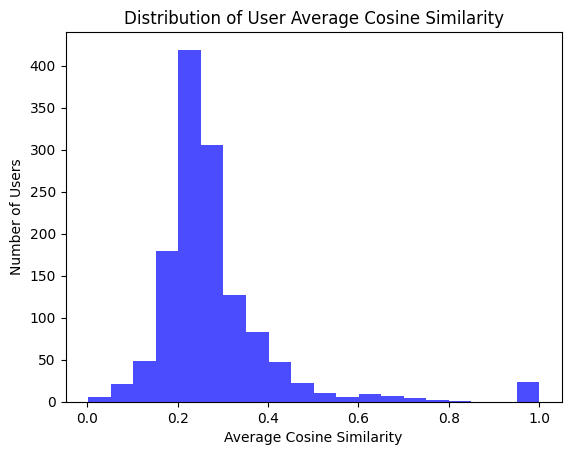

In [41]:
plt.hist(list(user_cosine_means.values()), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of User Average Cosine Similarity')
plt.xlabel('Average Cosine Similarity')
plt.ylabel('Number of Users')
plt.show()

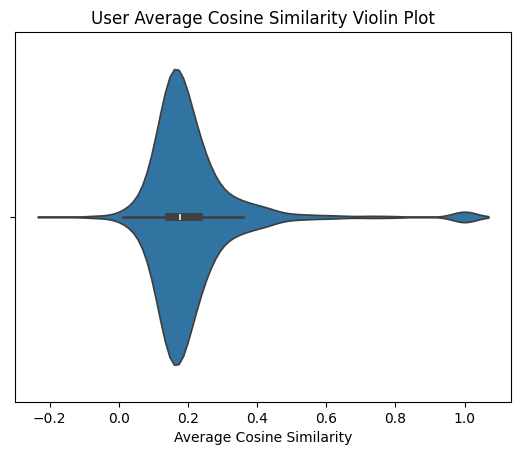

In [37]:
import seaborn as sns

# 바이올린 플롯 그리기
sns.violinplot(data=list(user_cosine_means.values()), orient='h')
plt.title('User Average Cosine Similarity Violin Plot')
plt.xlabel('Average Cosine Similarity')
plt.show()
